<a href="https://colab.research.google.com/github/iamviji/project/blob/master/End2EndQPSKRegularized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 199 (delta 83), reused 18 (delta 3), pack-reused 0
Receiving objects: 100% (199/199), 19.60 MiB | 12.17 MiB/s, done.
Resolving deltas: 100% (83/83), done.
ldpc_ber_18_11.png  project  sample_data
EncoderModulatorSplitArch.ipynb  MainModelKerasOneHot.ipynb
EncoderOutputExperiment.ipynb	 MainModelModCoding.ipynb
End2End8PSK.ipynb		 MainModelOneHotMethod.ipynb
End2EndOneHotQPSK.ipynb		 MainModelOneHotMethodSoftMax.ipynb
End2EndQPSK.ipynb		 MainModelWithSingleBERTraining.ipynb
End2EndQPSKRegularized.ipynb	 README.md
MainModel.ipynb			 util.py
MainModelKeras.ipynb


In [183]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

In [184]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [185]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [186]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 1 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 [0 0 1 ... 1 1 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 0 1 ... 1 1 0]
 [1 0 0 ... 1 0 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [187]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.76s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.39s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.05s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.75s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 16.95s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.46s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.92s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.38s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.91s
SNR: 0.500:
 -> BER: 0.51
 -> Total Time: 14.66s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.31s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.43s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.52s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.76s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 12.02s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.90s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.89s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [188]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.65s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.08s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.62s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.08s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 15.43s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.13s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.58s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.82s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.07s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 12.60s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.02s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.16s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.29s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.40s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 10.86s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.76s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.67s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [189]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.51s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.60s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.01s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 15.23s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.43s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.69s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.12s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.38s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 13.61s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.19s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.33s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.36s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.38s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 11.27s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.76s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.47s
SNR: 1.500 - Iter: 750 - Last 250.0 it

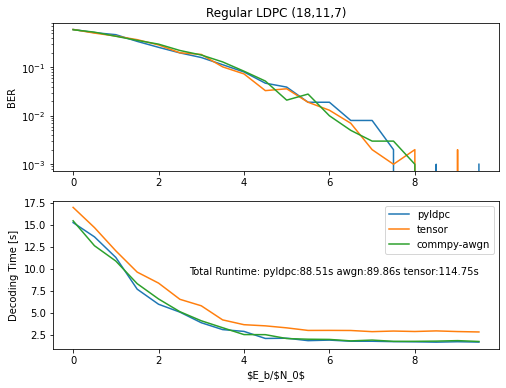

In [190]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [191]:
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

In [192]:
# Define Model 

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")
input_channel_out_ex = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_out_ex")
weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))

  #x = tf.sqrt(tf.reduce_sum(tf.square(layer_1), axis=1))
  #x = tf.reshape (x, (-1,1))
  #layer_2 = layer_1 / x


  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)
#print(numpy.mean(numpy.sqrt((numpy.square(regularizer_const*regularizer_const - encoded_message*encoded_message)))))
#print (numpy.mean(numpy.sqrt(numpy.square(numpy.multiply(regularizer_const-encoded_message, encoded_message)))))


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) )) + tf.reduce_max(tf.sqrt(tf.square(tf.math.multiply(input_channel_out_ex - dl_encoder_output, dl_encoder_output))))
loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) )) + tf.reduce_max((tf.square(input_channel_out_ex*input_channel_out_ex - dl_encoder_output*dl_encoder_output)))
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)
#rms_optimizer1 = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)

input_message_length= 11


In [193]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 0 1]
 [0 1 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [1 1 0 ... 0 1 1]]
10000


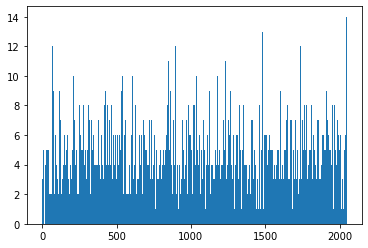

In [194]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

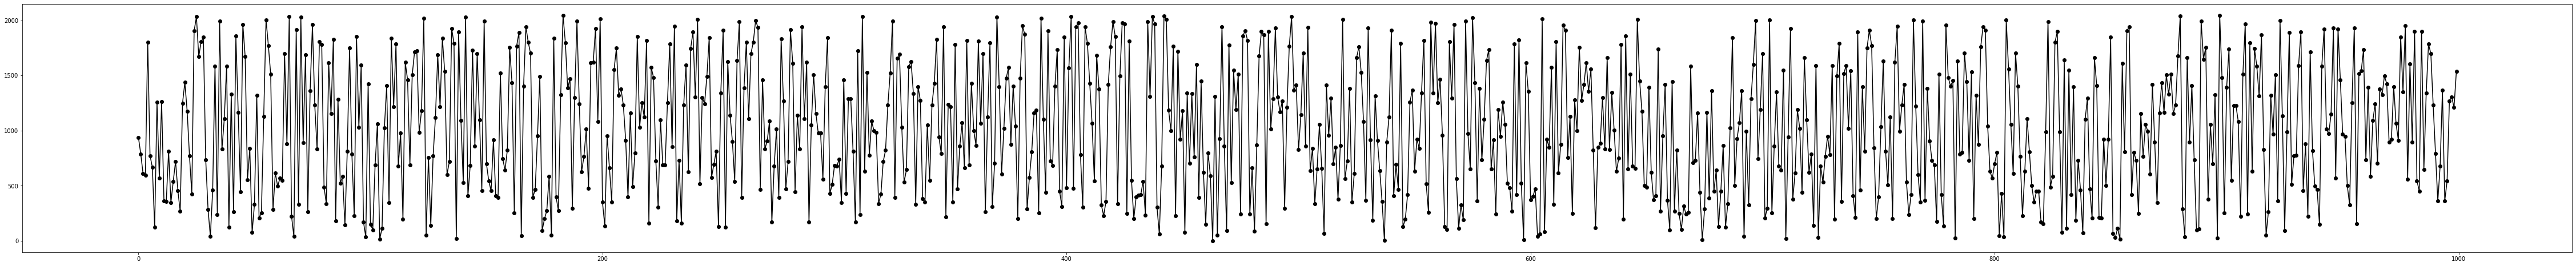

In [195]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')

In [202]:
#learning : Suddenly drops after 8 SNR
batch_size = 500


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 40
outer_ephocs = 1
num_of_batches = len(training_input_message) / batch_size
display_step = 400
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = .1
opt = rms_optimizer 
regularizer_const = numpy.ones((batch_size,CHANEL_SIZE), dtype=int)
#print (regularizer_const.shape)
#print (regularizer_const)
for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    if (snr>6): epochs = 200
    print ("Training for SNR=", snr, " sigma=", sigma) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        k = e * epochs + j
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate, input_channel_out_ex:regularizer_const})
        encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:x_train_batch_float})
        encoded_message = numpy.asarray(encoded_message[0])
        #print (encoded_message)
        #print ("loss:", l)
        #print (numpy.multiply(regularizer_const-encoded_message, encoded_message))
        #print (numpy.mean(numpy.sqrt(numpy.square(numpy.multiply(regularizer_const-encoded_message, encoded_message)))))
        #print(numpy.mean(numpy.sqrt((numpy.square(regularizer_const*regularizer_const - encoded_message*encoded_message)))))
        
        if (l < 0.5): lrate = 0.001
        if (l < 0.25): lrate = 0.0005
        if (l < 0.1): lrate = 0.00002
        if k % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))

batch_size: 500 num_of_batcches: 20.0
Training for SNR= 0.0  sigma= 1.0
Step 0: Minibatch Loss: 2.046858
Step 0: Minibatch Loss: 1.314025
Step 0: Minibatch Loss: 1.336443
Step 0: Minibatch Loss: 1.360379
Training for SNR= 0.5  sigma= 0.9440608762859234
Step 0: Minibatch Loss: 1.342885
Step 0: Minibatch Loss: 1.207591
Step 0: Minibatch Loss: 1.347175
Step 0: Minibatch Loss: 1.342037
Training for SNR= 1.0  sigma= 0.8912509381337456
Step 0: Minibatch Loss: 1.327049
Step 0: Minibatch Loss: 1.347318
Step 0: Minibatch Loss: 1.337530
Step 0: Minibatch Loss: 1.332837
Training for SNR= 1.5  sigma= 0.8413951416451951
Step 0: Minibatch Loss: 1.330344
Step 0: Minibatch Loss: 1.333455
Step 0: Minibatch Loss: 1.327380
Step 0: Minibatch Loss: 1.340501
Training for SNR= 2.0  sigma= 0.7943282347242815
Step 0: Minibatch Loss: 1.348943
Step 0: Minibatch Loss: 1.350931
Step 0: Minibatch Loss: 1.335447
Step 0: Minibatch Loss: 1.324785
Training for SNR= 2.5  sigma= 0.7498942093324559
Step 0: Minibatch Loss:

In [197]:
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

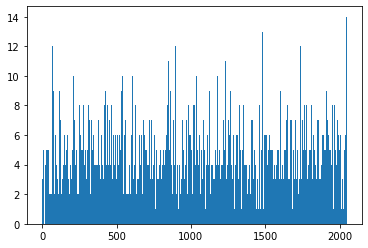

In [203]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

In [204]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
data_category = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    data_category.append (training_input_message_decimal [i:i+1][0])
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    channel_in.append(encoded_message[0][0]) 
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_out.append(awgn_channel_output_message[0]) 
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.46s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.73s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.29s
SNR: 0.000:
 -> BER: 0.95
 -> Total Time: 3.49s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.83s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.11s
SNR: 0.500:
 -> BER: 0.95
 -> Total Time: 2.76s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.84s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.12s
SNR: 1.000:
 -> BER: 0.92
 -> Total Time: 2.82s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [205]:
#print (channel_in[-1])
channel_in_tr = channel_in
#channel_in_tr.append (-1*numpy.ones((CHANEL_SIZE), dtype=int))
#channel_in_tr.append (numpy.ones((CHANEL_SIZE), dtype=int))
#data_category.append(0)
#data_category.append(0)
#print (-1*numpy.ones((1,CHANEL_SIZE), dtype=int))
#print (channel_in[-1])
print (numpy.array(channel_in_tr).shape)

(20000, 18)


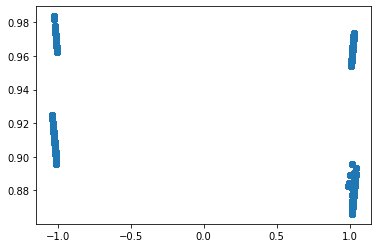

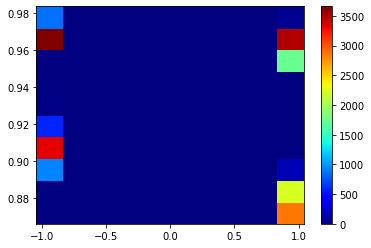

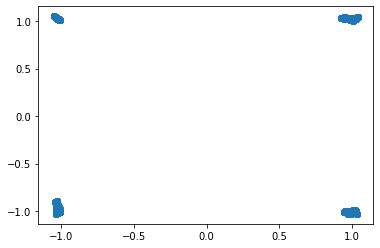

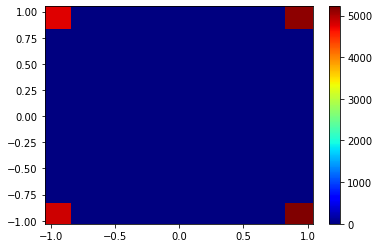

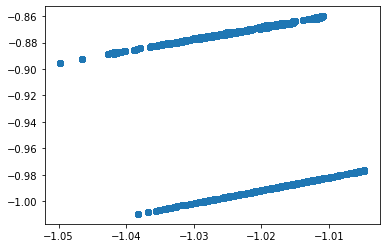

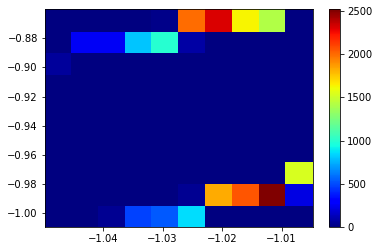

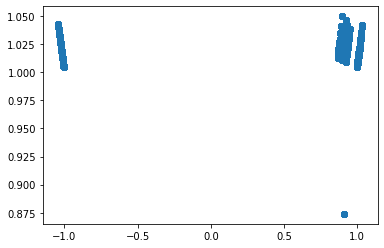

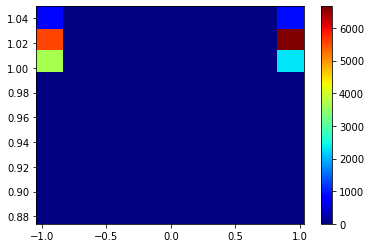

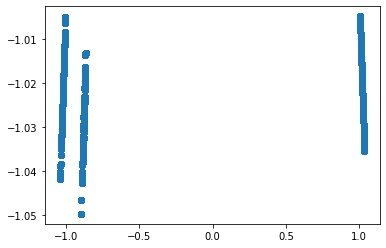

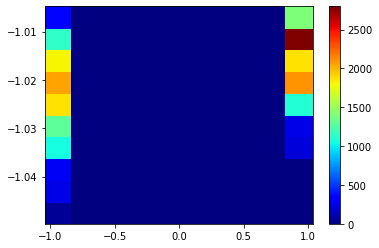

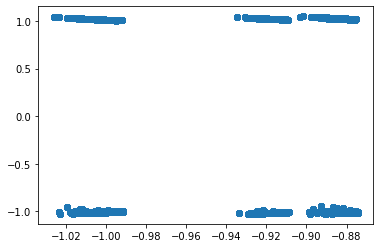

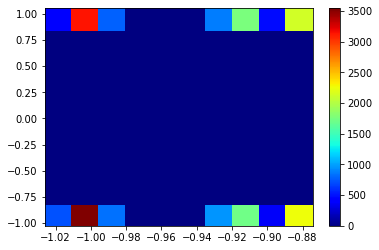

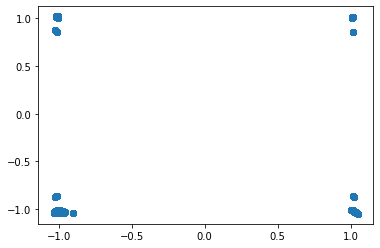

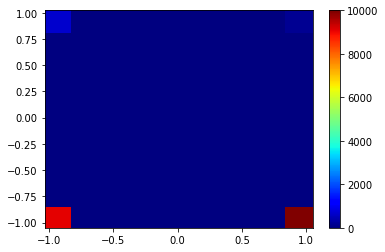

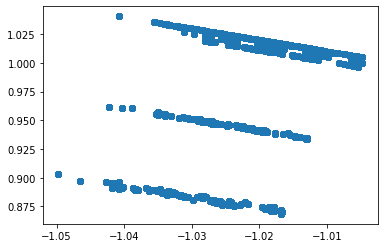

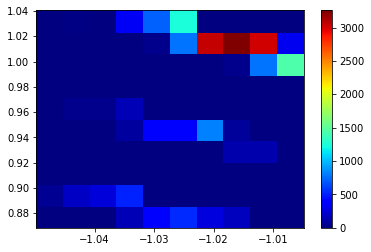

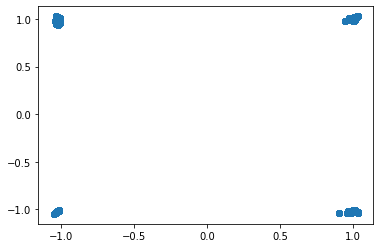

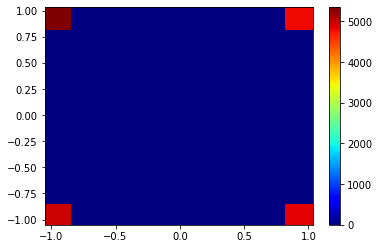

In [206]:
channel_in_array = numpy.transpose(channel_in_tr)
#channel_in_array = numpy.transpose(channel_in_array)
#print (channel_in_array)
import matplotlib.pyplot as plt
for i in range (int(CHANEL_SIZE/2)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [207]:
channel_out_tr = channel_out
#channel_out_tr.append (-1*numpy.ones((CHANEL_SIZE), dtype=int))
#channel_out_tr.append (numpy.ones((CHANEL_SIZE), dtype=int))


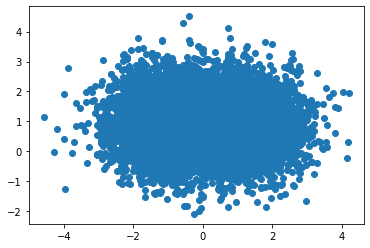

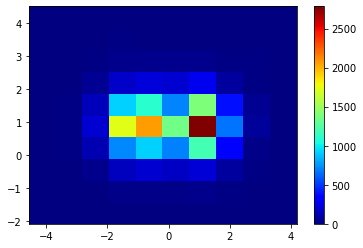

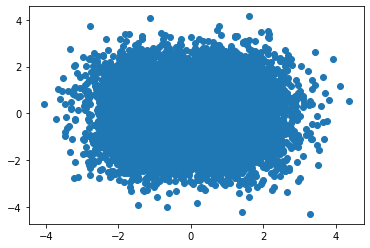

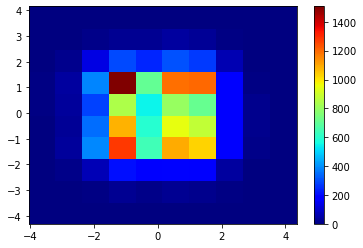

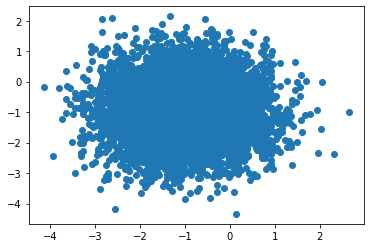

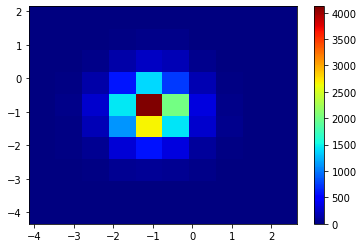

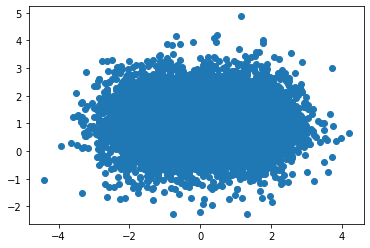

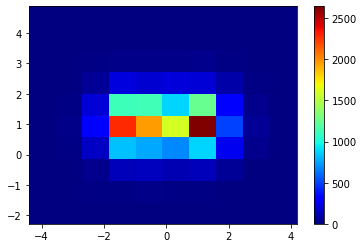

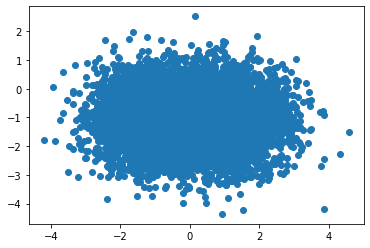

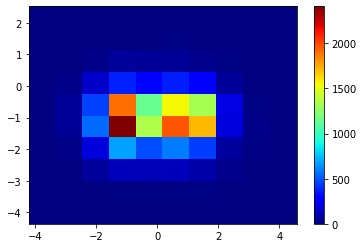

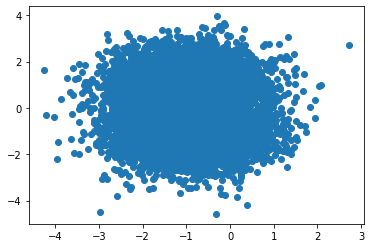

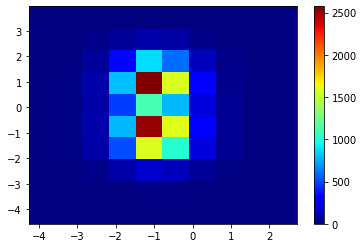

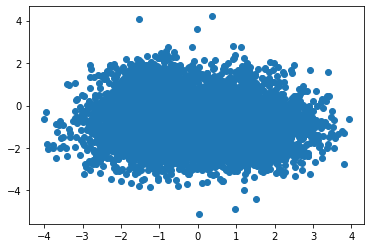

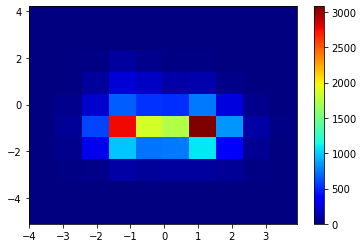

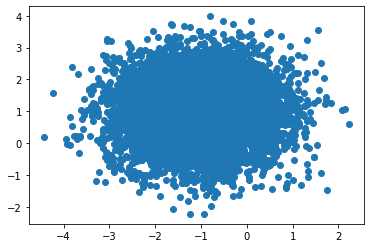

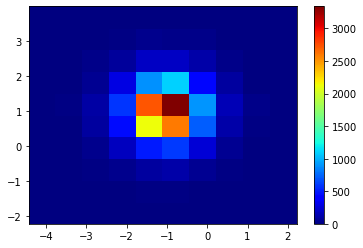

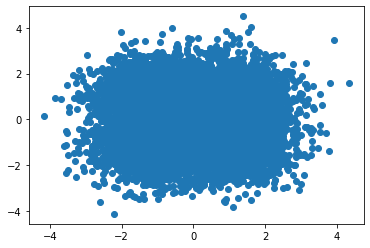

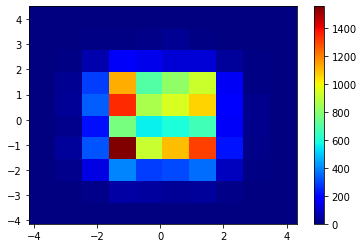

In [208]:
channel_out_array = numpy.transpose(channel_out_tr)
import matplotlib.pyplot as plt
for i in range (int(CHANEL_SIZE/2)):
  plt.scatter(channel_out_array[i*2], channel_out_array[i*2+1])
  plt.show()
  plt.hist2d(channel_out_array[i*2], channel_out_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

[ 1.0198529  1.0115707 -1.0129759 ...  1.0311201 -1.0191288 -1.0047631]


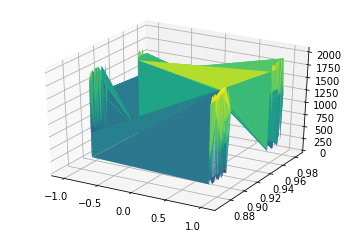

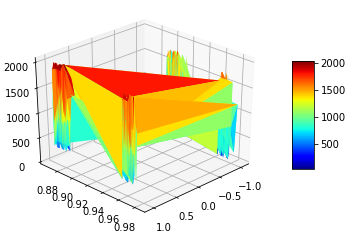

In [214]:
import pandas as pd
import seaborn
print (channel_in_array[0])
df = pd.DataFrame({'X':channel_in_array[0],'Y':channel_in_array[1],'value':data_category})

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['X'], df['Y'], df['value'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

fig = plt.figure()

ax = fig.gca(projection='3d')
ax.view_init(30, 45)
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['X'], df['Y'], df['value'], cmap=plt.cm.jet, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()




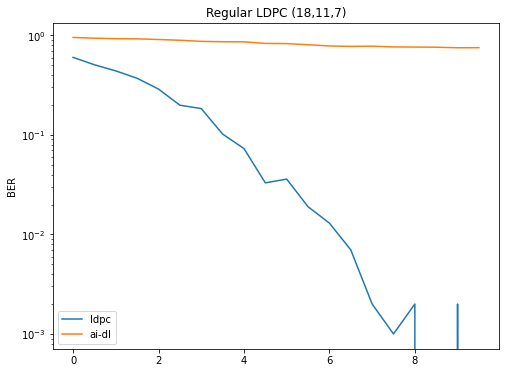

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [219]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    encoded_message = numpy.around(encoded_message[0][0]).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.30s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.86s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.13s
SNR: 0.000:
 -> BER: 0.95
 -> Total Time: 2.86s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.53s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.83s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.10s
SNR: 0.500:
 -> BER: 0.93
 -> Total Time: 2.74s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.83s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.11s
SNR: 1.000:
 -> BER: 0.93
 -> Total Time: 2.76s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [209]:
testing_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))


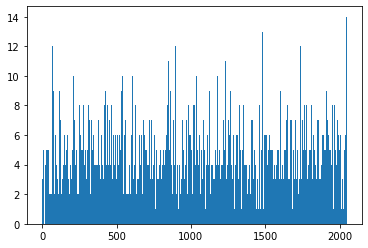

In [210]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
testing_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(testing_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(testing_input_message_decimal, bins = x_axis) 
plt.show()

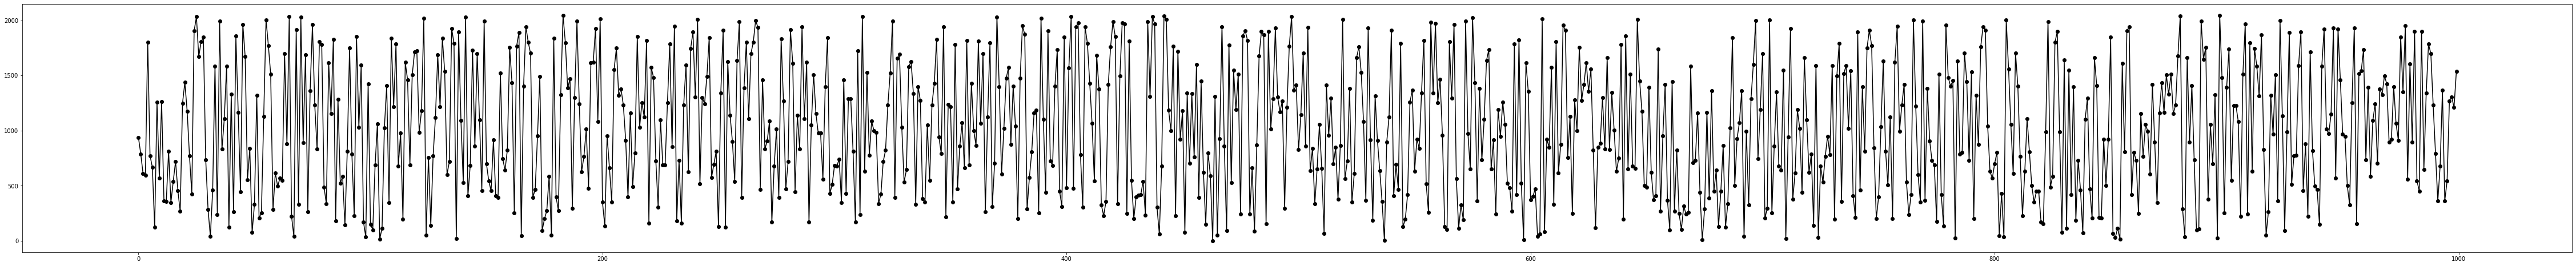

In [211]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],testing_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')

In [212]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = testing_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
   #x = numpy.round(encoded_message[0][0])
    x = encoded_message[0][0]
    #print (x)
    #awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:x})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-testing_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.34s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.62s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.90s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.16s
SNR: 0.000:
 -> BER: 0.95
 -> Total Time: 3.02s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.86s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.14s
SNR: 0.500:
 -> BER: 0.94
 -> Total Time: 2.85s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.82s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.09s
SNR: 1.000:
 -> BER: 0.93
 -> Total Time: 2.74s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.60s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

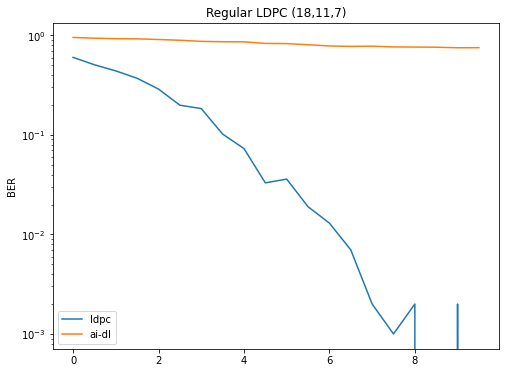

In [213]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [220]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = testing_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    x = numpy.round(encoded_message[0][0])
    #x = encoded_message[0][0]
    #print (x)
    #awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:x})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-testing_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.38s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.80s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.22s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.63s
SNR: 0.000:
 -> BER: 0.94
 -> Total Time: 4.01s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.41s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.82s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.25s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.57s
SNR: 0.500:
 -> BER: 0.93
 -> Total Time: 4.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.58s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.85s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.11s
SNR: 1.000:
 -> BER: 0.94
 -> Total Time: 2.82s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.31s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.60s
SNR: 1.500 - Iter: 750 - Last 250.0 itera